# Make Supplemental Figure 1

This notebook graphs the cis effect of EGFR copy number and phosphoproteomics. It graphs sites Y1197, Y1172, Y1110, Y1092, Y1069, Y1016, Y869 if there is enough data available [cite].

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import cptac
import cptac.utils as u
import plot_utils as p

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def myTrunc(theNumber, theDigits):

    myDigits = 10 ** theDigits
    return (int(theNumber * myDigits) / myDigits)

In [3]:
def plot_pearson(df1,x_axis, y_axis, hue = "none", title = "", ra_stats = False, show_plot = True, save_file_name = "file_name"):
    if hue != "none":   
        df1_subset = df1[[x_axis,y_axis,hue]]
        df1_subset = df1_subset.dropna(axis=0, how="any")
        count_row = df1_subset.shape[0]
        if count_row > 30:
            x1 = df1_subset[[x_axis]].values
            y1 = df1_subset[[y_axis]].values
            x1 = x1[:,0]
            y1 = y1[:,0]
            corr, pval = scipy.stats.pearsonr(x1,y1)
            sns.set(style="darkgrid")
            plt.rcParams["figure.figsize"] = (30,22)
            graph = sns.lmplot(x= x_axis, y= y_axis, data=df1_subset, hue= hue, fit_reg=False)
            sns.regplot(x=x1, y=y1, data=df1_subset,scatter = False)
            graph.set(title = title)
        else: 
            return "Not Enough Data"
   
    if hue == "none":
        
        df1_subset = df1[[x_axis,y_axis]]
        df1_subset = df1_subset.dropna(axis=0, how="any")
        count_row = df1_subset.shape[0]
        if count_row > 30:
            x1 = df1_subset[[x_axis]].values
            y1 = df1_subset[[y_axis]].values
            x1 = x1[:,0]
            y1 = y1[:,0]
            corr, pval = scipy.stats.pearsonr(x1,y1)

            sns.set(style="darkgrid")
            graph = sns.lmplot(x= x_axis, y= y_axis, data=df1_subset, fit_reg=False)
            sns.regplot(x=x1, y=y1, data=df1_subset,scatter = False)
            plt.title(label = title, fontsize = 30)
            plt.xlabel('EGFR CNV', fontsize=20)
            plt.ylabel(y_axis, fontsize=20)
            plt.xticks(fontsize = 17)
            plt.yticks(fontsize = 17)
        else:
            return "Not Enough Data"

    if ra_stats:
        pval = myTrunc(pval,31)
        corr = myTrunc(corr,3)
        plt.text(1,0, "Correlation: %s\nPvalue: %s"%(corr,pval))
        
    if save_file_name != "file_name":
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.savefig(save_file_name+'.png', dpi = 300)
    if show_plot:
        plt.show()
        plt.clf()
        plt.close()

In [4]:
def print_stats(df1, x_axis, y_axis):
      
    df1_subset = df1[[x_axis,y_axis]]
    df1_subset = df1_subset.dropna(axis=0, how="any")
    count_row = df1_subset.shape[0]
    if count_row > 30:
        x1 = df1_subset[[x_axis]].values
        y1 = df1_subset[[y_axis]].values
        x1 = x1[:,0]
        y1 = y1[:,0]
        corr, pval = scipy.stats.pearsonr(x1,y1)
        print("Correlation: " + str(corr))
        print("P_value:" + str(pval))
  
    else: 
        return "Not Enough Data"
   

In [5]:
#Load cptac data sets
brain = cptac.Gbm()
kidney = cptac.Ccrcc()
Ovar = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
luad = cptac.Luad()
Hnscc = cptac.Hnscc()
Lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 2)


cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 8)


version 3scc v3.2.......                 


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 9)


In [6]:
def get_only_tumors(df, cancer):
    
    mutation = cancer.get_clinical()
    mergedDf = df.merge(mutation, on="Patient_ID")
    phospho_CNV_Tumor = mergedDf.loc[mergedDf['Sample_Tumor_Normal'] == "Tumor"]
    return phospho_CNV_Tumor

# Step 1 Create Data Frame

For each cancer type create a df that combines proteomics and CNV. Then merge clinical dataframe and filter df to only have tumor samples. 

# Step 2  Call Plotting Function

# GBM

In [37]:
df1 = brain.get_phosphoproteomics()
df2 = brain.get_CNV()
df2 = df2[["EGFR"]]
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)
phospho_cnv = df1.merge(df2, on="Patient_ID")

phospho_CNV_Tumor = get_only_tumors(phospho_cnv, brain)

phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)


,EGFR_Y1092,EGFR_Y1110,EGFR_Y1125,EGFR_Y1125T1145,EGFR_Y1172,EGFR_Y1197,EGFR_Y316,EGFR_Y316,EGFR_Y764,EGFR_Y998
Patient_ID,,,,,,,,,,
C3L-00104,NaN,0.713628,NaN,NaN,1.977394,2.326907,NaN,-4.554552,NaN,NaN
C3L-00365,NaN,1.900383,NaN,NaN,3.831216,4.392495,NaN,-0.689090,NaN,0.992811
C3L-00674,0.421457,-0.851118,-0.572868,0.459301,-0.152648,0.521459,0.231844,0.000535,NaN,0.183023
C3L-00677,-1.548885,0.399811,NaN,NaN,-1.365995,-1.272197,NaN,-0.933573,NaN,NaN
C3L-01040,NaN,-0.209843,NaN,NaN,-0.710159,-3.047771,NaN,-0.652991,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
C3N-03183,NaN,NaN,NaN,NaN,-0.303561,-1.838129,NaN,-0.754862,NaN,-0.623662
C3N-03184,0.150344,0.062236,NaN,NaN,0.221283,-0.274030,0.533673,3.678630,NaN,NaN
C3N-03186,-1.385977,-0.146275,NaN,NaN,-1.305470,-0.255198,NaN,-0.353529,NaN,-0.202275


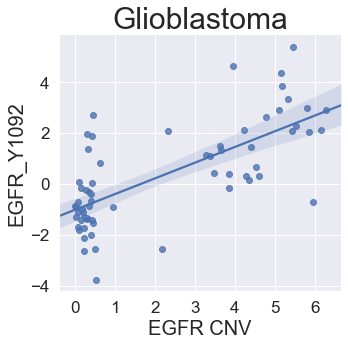

Correlation: 0.7036546954007359
P_value:8.882401626005035e-11


In [38]:
plot_pearson(phospho_CNV_Tumor ,"EGFR","EGFR_Y1092", hue = "none", title = "Glioblastoma", ra_stats = False ,show_plot = True, save_file_name = "png_files/Step2Cis_Gbm_Y1092")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1092")

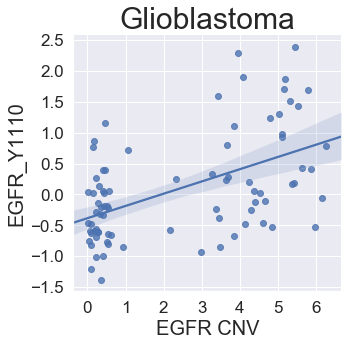

Correlation: 0.5179127088188711
P_value:6.255314235437412e-07


In [39]:
plot_pearson(phospho_CNV_Tumor ,"EGFR","EGFR_Y1110", hue = "none", title = "Glioblastoma", ra_stats = False ,show_plot = True, save_file_name = "png_files/Step2Cis_Gbm_Y1110")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1110")

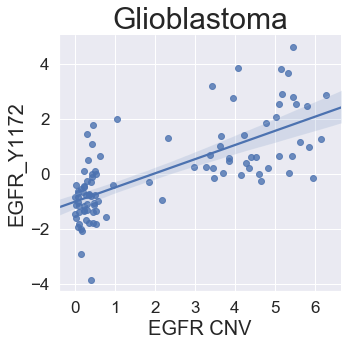

Correlation: 0.7112472011749407
P_value:2.2787391749727397e-16


In [40]:
plot_pearson(phospho_CNV_Tumor ,"EGFR","EGFR_Y1172", hue = "none", title = "Glioblastoma", ra_stats = False ,show_plot = True, save_file_name = "png_files/Step2Cis_GBM_Y1172")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1172")

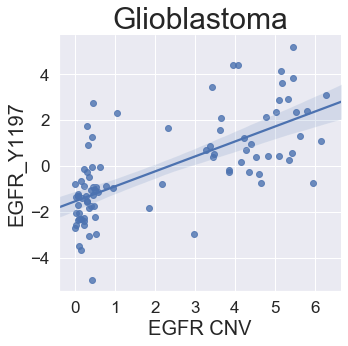

Correlation: 0.6873104154301388
P_value:7.373036188228447e-14


In [41]:
plot_pearson(phospho_CNV_Tumor ,"EGFR","EGFR_Y1197", hue = "none", title = "Glioblastoma", ra_stats = False ,show_plot = True, save_file_name = "png_files/Step2Cis_GBM_Y1197")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1197")

# Kidney 

In [43]:
df1 = kidney.get_phosphoproteomics()
df2 = kidney.get_CNV()
df2 = df2[["EGFR"]]
df2.columns = df2.columns.droplevel(1)
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)
phospho_cnv = df1.merge(df2, on="Patient_ID")

phospho_CNV_Tumor = get_only_tumors(phospho_cnv, kidney)

phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)

,EGFR_Y1016,EGFR_Y1039,EGFR_Y1119,EGFR_Y1144,EGFR_Y963
Patient_ID,,,,,
C3L-00004,NaN,0.285696,NaN,0.999000,-0.013055
C3L-00010,NaN,0.601337,0.412977,0.700833,NaN
C3L-00011,NaN,-0.239413,0.271045,-0.430652,NaN
C3L-00026,NaN,0.444422,1.011546,0.465533,0.460270
C3L-00079,NaN,NaN,-0.000500,NaN,0.040108
...,...,...,...,...,...
C3N-01646,NaN,-0.160831,NaN,-0.404793,NaN
C3N-01648,NaN,-0.413072,NaN,-0.650702,NaN
C3N-01649,NaN,0.353399,-0.059095,0.369224,-0.250412


In [44]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1016", hue ="none", ra_stats = False, show_plot = True, title = "Renal")


'Not Enough Data'

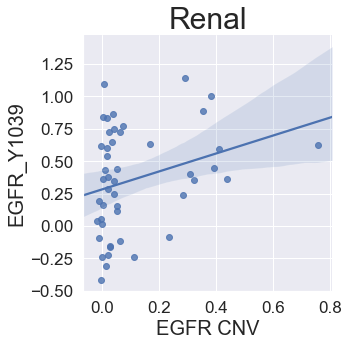

Correlation: 0.28851497059002085
P_value:0.049212865959710334


In [13]:
#Not one of the 7 phospho sites in paper
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1039", hue ="none", ra_stats = False, show_plot = True, title = "Renal", save_file_name = "png_files/Step2Cis_Kidney_Y1039")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1039")

# Ovarian 

In [14]:
df1 = Ovar.get_phosphoproteomics()
df2 = Ovar.get_CNV()
df2 = df2[["EGFR"]]
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)
phospho_cnv = df1.merge(df2, on="Patient_ID")

phospho_CNV_Tumor = get_only_tumors(phospho_cnv, Ovar)


phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)


,EGFR_Y1172,EGFR_Y1197,EGFR_Y869
Patient_ID,,,
01OV007,-2.216,NaN,NaN
01OV017,-2.202,NaN,NaN
01OV018,NaN,NaN,NaN
01OV023,NaN,NaN,NaN
01OV026,NaN,NaN,NaN
...,...,...,...
26OV002,-2.261,NaN,NaN
26OV008,NaN,NaN,-1.735
26OV009,NaN,NaN,-1.620


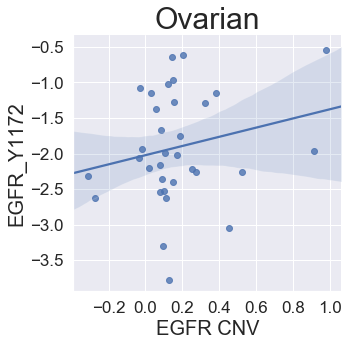

Correlation: 0.21515112287280874
P_value:0.22919425449408157


In [15]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1172", hue = "none", ra_stats = False,title = "Ovarian", show_plot = True, save_file_name = "png_files/Step2Cis_Ovarian_Y1172")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1172")

In [16]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y869", hue = "none", ra_stats = False,title = "Ovarian", show_plot = True)

'Not Enough Data'

In [17]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1197", hue = "none", ra_stats = False,title = "Ovarian", show_plot = True)

'Not Enough Data'

# Colon

In [18]:
df1 = colon.get_phosphoproteomics()
df2 = colon.get_CNV()
df2 = df2[["EGFR"]]
#df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)

phospho_cnv = df1.merge(df2, on="Patient_ID")

phospho_CNV_Tumor = get_only_tumors(phospho_cnv, colon)

phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)

,EGFR_Y1092,EGFR_Y1172,EGFR_Y1197
Patient_ID,,,
01CO005,NaN,NaN,-1.002
01CO006,0.178,-0.421,NaN
01CO008,-0.784,NaN,NaN
01CO013,NaN,NaN,NaN
01CO014,NaN,NaN,NaN
...,...,...,...
21CO006,NaN,NaN,NaN
21CO007,-0.396,NaN,NaN
22CO004,NaN,NaN,NaN


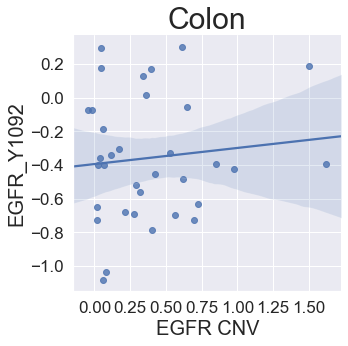

Correlation: 0.10671722068889092
P_value:0.5480350434391613


In [19]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1092",hue = "none", ra_stats = False, title = "Colon", show_plot = True, save_file_name = "png_files/Step2Cis_Colon_Y1092")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1092")


In [20]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1172",hue = "none", ra_stats = False, title = "Colon", show_plot = True)


'Not Enough Data'

In [21]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1197",hue = "none", ra_stats = False, title = "Colon", show_plot = True)


'Not Enough Data'

# Brca 

In [22]:
df1 = brca.get_phosphoproteomics()
df2 = brca.get_CNV()
df2 = df2[["EGFR"]]
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)

phospho_cnv = df1.merge(df2, on="Patient_ID")
mutation = colon.get_clinical()
mergedDf = phospho_cnv.merge(mutation, on="Patient_ID")
phospho_CNV_Tumor = mergedDf.loc[mergedDf['Sample_Tumor_Normal'] == "Tumor"]


phospho_CNV_Tumor.filter(like='EGFR_', axis=1)

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,EGFR_S1039,EGFR_S1064,EGFR_S1166,EGFR_S991,EGFR_T1041S1042,EGFR_T693
Patient_ID,,,,,,


No Y sites

# LUAD

In [45]:
df1 = luad.get_phosphoproteomics()
df2 = luad.get_CNV()
df2 = df2[["EGFR"]]
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)

phospho_cnv = df1.merge(df2, on="Patient_ID")
mutation = luad.get_clinical()
mergedDf = phospho_cnv.merge(mutation, on="Patient_ID")
phospho_CNV_Tumor = mergedDf.loc[mergedDf['Sample_Tumor_Normal'] == "Tumor"]


phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)

,EGFR_Y1092,EGFR_Y1172,EGFR_Y1197
Patient_ID,,,
C3L-00001,NaN,5.9688,8.5140
C3L-00009,-2.0647,-1.0692,-1.3295
C3L-00080,NaN,NaN,-2.1724
C3L-00083,NaN,-2.7310,-2.2124
C3L-00093,NaN,-0.7893,0.7454
...,...,...,...
C3N-02729,NaN,2.8111,1.8433
X11LU013,NaN,1.0763,1.3651
X11LU016,NaN,-0.3352,-1.1907


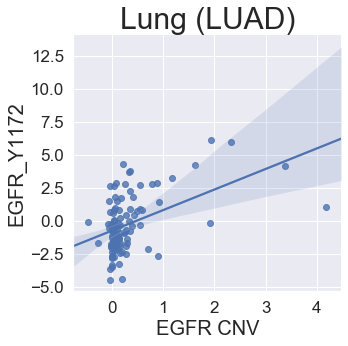

Correlation: 0.47017692146660944
P_value:7.014611131494685e-07


In [46]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1172", hue = 'none', title = "Lung (LUAD)", ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Luad_Y1172")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1172")

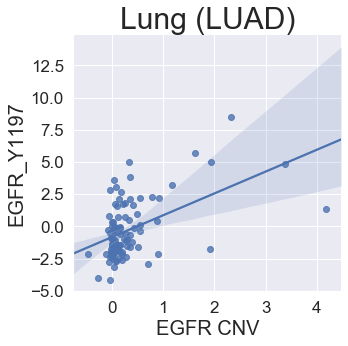

Correlation: 0.5017636428902341
P_value:1.9094474983954976e-07


In [47]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1197", hue = 'none', title = "Lung (LUAD)", ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Luad_Y1197")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1197")

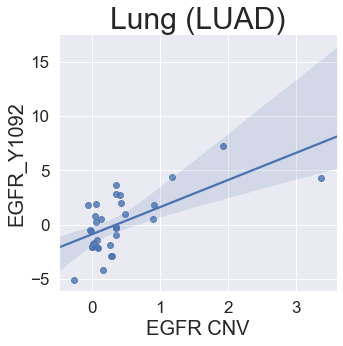

Correlation: 0.6403397550362737
P_value:7.905709366125327e-05


In [49]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1092", hue = 'none', title = "Lung (LUAD)", ra_stats = False,save_file_name = "png_files/Step2Cis_Luad_Y1092")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1092")

# HNSCC

In [27]:
df1 = Hnscc.get_phosphoproteomics()
df2 = Hnscc.get_CNV()
df2 = df2[["EGFR"]]
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)

phospho_cnv = df1.merge(df2, on="Patient_ID")
mutation = Hnscc.get_clinical()
mergedDf = phospho_cnv.merge(mutation, on="Patient_ID")
phospho_CNV_Tumor = mergedDf.loc[mergedDf['Sample_Tumor_Normal'] == "Tumor"]


phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)

,EGFR_Y1092,EGFR_Y1110,EGFR_Y1172,EGFR_Y1197,EGFR_Y727
Patient_ID,,,,,
C3L-00977,17.473013,NaN,20.292057,23.960771,NaN
C3L-00987,NaN,NaN,18.218061,21.464089,NaN
C3L-00994,16.886517,NaN,19.119405,22.517973,NaN
C3L-00995,NaN,NaN,NaN,22.753777,NaN
C3L-00997,NaN,16.956105,18.056164,21.358591,NaN
...,...,...,...,...,...
C3N-04277,NaN,18.134882,NaN,23.335068,NaN
C3N-04278,NaN,NaN,NaN,21.584917,NaN
C3N-04279,NaN,18.366149,19.220107,22.176533,NaN


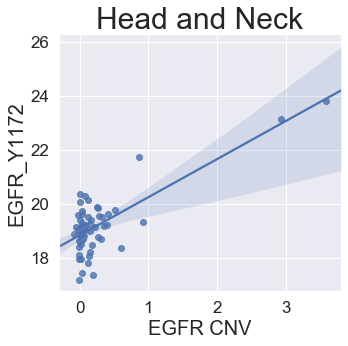

Correlation: 0.7584547976823564
P_value:3.4560670430401392e-12


In [28]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1172", hue = "none", title = "Head and Neck", ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Hnscc_Y1172")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1172")

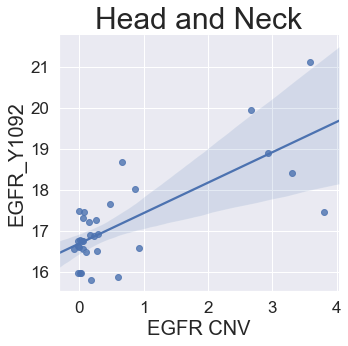

Correlation: 0.73771492456119
P_value:1.4534870866842714e-06


In [29]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1092", hue = "none", title = "Head and Neck", ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Hnscc_Y1092")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1092")

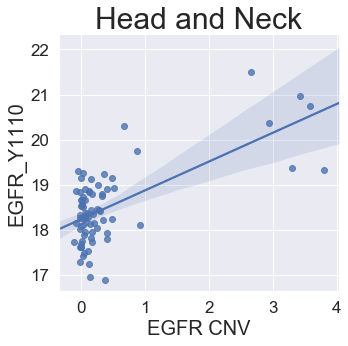

Correlation: 0.6580374863424965
P_value:7.881163387356222e-11


In [30]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1110", hue = "none", title = "Head and Neck", ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Hnscc_Y1110")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1110")

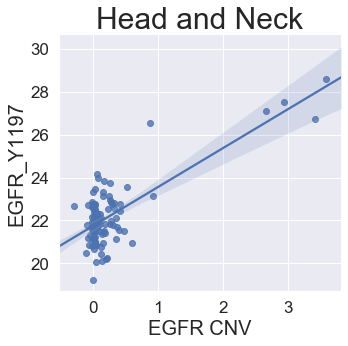

Correlation: 0.7549149385442053
P_value:4.993955456093028e-20


In [31]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1197", hue = "none", title = "Head and Neck", ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Hnscc_Y1197")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1197")

# LSCC

In [32]:
df1 = Lscc.get_phosphoproteomics()
df2 = Lscc.get_CNV()
df2 = df2[["EGFR"]]
df1.columns = df1.columns.droplevel(2)
df1.columns = df1.columns.droplevel(2)
df1.columns =df1.columns.map('_'.join)

phospho_cnv = df1.merge(df2, on="Patient_ID")
mutation = Lscc.get_clinical()
mergedDf = phospho_cnv.merge(mutation, on="Patient_ID")
phospho_CNV_Tumor = mergedDf.loc[mergedDf['Sample_Tumor_Normal'] == "Tumor"]


phospho_CNV_Tumor.filter(like='EGFR_Y', axis=1)

,EGFR_Y1172,EGFR_Y1197
Patient_ID,,
C3L-00081,1.0487,-0.7231
C3L-00415,-2.1963,-1.3811
C3L-00445,-0.2028,-1.0228
C3L-00568,0.2427,-1.4843
C3L-00603,-0.6293,-1.3100
...,...,...
C3N-03886,-2.9095,-1.6461
C3N-04124,-0.6279,-1.5550
C3N-04127,-2.0908,NaN


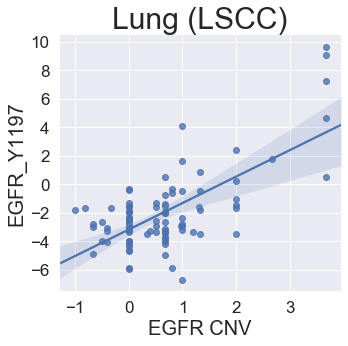

Correlation: 0.6837399672468735
P_value:1.6267741391193885e-14


In [33]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1197", hue = "none", title = "Lung (LSCC)" , ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Lscc_Y1197")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1197")

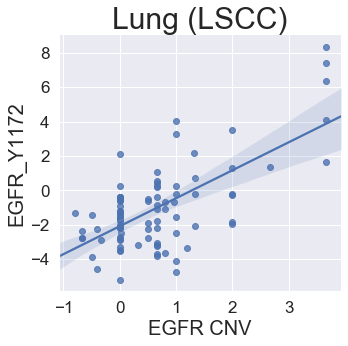

Correlation: 0.6687252113103791
P_value:3.2248076162506454e-13


In [34]:
plot_pearson(phospho_CNV_Tumor,"EGFR","EGFR_Y1172", hue = "none", title = "Lung (LSCC)" , ra_stats = False, show_plot = True, save_file_name = "png_files/Step2Cis_Lscc_Y1172")
print_stats(phospho_CNV_Tumor,"EGFR","EGFR_Y1172")